# Sommaire

1. Importation des packages
2. Importation des données
3. Etude du jeu de données
4. Préparation des données
5. Entraînement du modèle baseline
6. Itération de la modélisation
7. Pipeline et classification

# Importation des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dyrudis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dyrudis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dyrudis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Importation des données

In [2]:
# Lecture des données
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# On ne garde que les 5000 premiers exemples (pour les tests)
train = train[:15000]

# On supprime la colonne 'id' qui ne nous sert pas
train = train.drop('id', axis=1)

# Affichage des données
train.head(2374)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
2369,(UTC) This sentence is an editorial opinion an...,0,0,0,0,0,0
2370,Have you a brit? \n\nThats for you! 80.99.29.195,0,0,0,0,0,0
2371,"Don't Talk\nGoogie Man, I got 2 simple words f...",1,0,0,0,0,0
2372,"""\n\nwhy don't you """"REMOVE"""" my free speech y...",1,0,1,0,1,0


# Etude du jeu de données

In [3]:
# On affiche le nombre de commentaires de chaque catégorie
train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

toxic            1439
severe_toxic      158
obscene           789
threat             50
insult            749
identity_hate     133
dtype: int64

In [4]:
# Affichage d'un commentaire aléatoire pour chaque catégorie
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    sample = train[train[column] == 1]['comment_text'].sample(1)
    print(f"Commentaire pour la colonne {column} :\n\"{sample}\"\n")

Commentaire pour la colonne toxic :
"700    Matt, when mattsanchez.info goes live on Monda...
Name: comment_text, dtype: object"

Commentaire pour la colonne severe_toxic :
"6063    n i g g e r f a g g o t
Name: comment_text, dtype: object"

Commentaire pour la colonne obscene :
"4671    Penis \n\nDid you sex with Grawp? H-A-6-6-E-P?...
Name: comment_text, dtype: object"

Commentaire pour la colonne threat :
"9650    That's it. Remember last time you fucked with ...
Name: comment_text, dtype: object"

Commentaire pour la colonne insult :
"1928    Moral Defense, you slimy toad you.
Name: comment_text, dtype: object"

Commentaire pour la colonne identity_hate :
"2469    "\nActually I am fully Arabic and Islamic and ...
Name: comment_text, dtype: object"



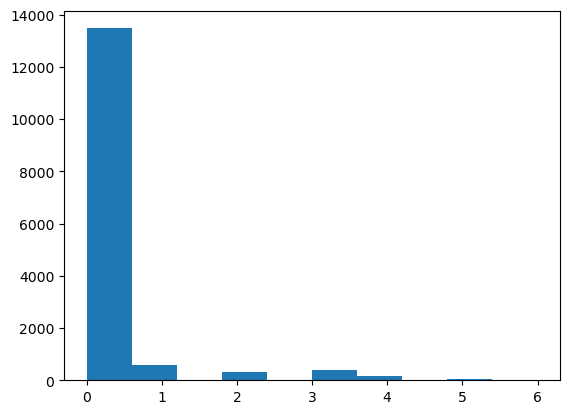

In [5]:
# Affichage du nombre de commentaires avec un certain nombre de catégories
# On voit que la plupart des commentaires sont neutres
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = np.sum(labels, axis=1)
plt.hist(labels)
plt.show()

# Préparation des données

In [6]:
# On met les commentaires en minuscules
train['comment_text'] = train['comment_text'].str.lower()

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [7]:
# On supprime les caractères spéciaux et on sépare les mots avec nltk
tokenizer = nltk.RegexpTokenizer(r'\w+')
train['comment_text'] = train['comment_text'].apply(tokenizer.tokenize)

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, why, the, edits, made, under, my...",0,0,0,0,0,0
1,"[d, aww, he, matches, this, background, colour...",0,0,0,0,0,0
2,"[hey, man, i, m, really, not, trying, to, edit...",0,0,0,0,0,0
3,"[more, i, can, t, make, any, real, suggestions...",0,0,0,0,0,0
4,"[you, sir, are, my, hero, any, chance, you, re...",0,0,0,0,0,0


In [8]:
# On supprime les stopwords
stopwords = nltk.corpus.stopwords.words()
train['comment_text'] = train['comment_text'].apply(lambda x: [word for word in x if word not in stopwords])

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,"[aww, matches, background, colour, seemingly, ...",0,0,0,0,0,0
2,"[hey, edit, guy, constantly, removing, relevan...",0,0,0,0,0,0
3,"[make, real, suggestions, improvement, wondere...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [9]:
# On lemmatise les mots
Word_Lemmatizer = WordNetLemmatizer()
train['comment_text'] = train['comment_text'].apply(lambda x: [Word_Lemmatizer.lemmatize(word) for word in x])

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,"[aww, match, background, colour, seemingly, st...",0,0,0,0,0,0
2,"[hey, edit, guy, constantly, removing, relevan...",0,0,0,0,0,0
3,"[make, real, suggestion, improvement, wondered...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [10]:
# Enfin, on reconstitue les phrases
sentences = list(map(lambda x : " ".join(x), train['comment_text']))

# Affichage des données
sentences[:3]

['explanation edits made username hardcore metallica reverted vandalism closure gas voted york doll fac remove template talk page retired 89 205 38 27',
 'aww match background colour seemingly stuck talk 21 51 january 11 2016 utc',
 'hey edit guy constantly removing relevant information talking edits instead talk page formatting actual info']

# Entraînement du modèle baseline

In [11]:
# Pour le premier modèle, on va utiliser un Random Forest Classifier
# Avant cela, on va vectoriser les phrases avec TF-IDF
vectorizer = TfidfVectorizer()

# On fit le vectorizer sur les phrases
vectorizer.fit(sentences)

# On transforme les phrases en vecteurs
vectors = vectorizer.transform(sentences)

# Séparation des données en train et test
train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.1, random_state=0)

# Affichage des dimensions des données
print(f"Train sequences shape : {train_vectors.shape}")
print(f"Test sequences shape : {test_vectors.shape}")
print(f"Train labels shape : {train_labels.shape}")
print(f"Test labels shape : {test_labels.shape}")

Train sequences shape : (13500, 41870)
Test sequences shape : (1500, 41870)
Train labels shape : (13500,)
Test labels shape : (1500,)


In [12]:
# Maintenant, on peut créer le modèle
model = RandomForestClassifier(n_estimators=15,random_state=0)

# Entrainement du modèle
model.fit(train_vectors, train_labels)

# Prédiction sur les données de test
predictions = model.predict(test_vectors)

# Affichage de l'accuracy
print(f"Accuracy : {accuracy_score(test_labels, predictions)}")

Accuracy : 0.9186666666666666


# Itération de la modélisation

In [13]:
# Pour le deuxième modèle, on va utiliser un réseau de neurones récurrent (RNN)
# Avant cela, on va tokeniser les phrases et leur donner la même longueur

# Création du tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)

# Récupération du vocabulaire
word_index = tokenizer.word_index
vocab_size = len(word_index)

# Tokenisation des phrases
sequences = tokenizer.texts_to_sequences(sentences)

# Padding des phrases
max_length = 200
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
labels = np.array(train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values)

# Séparation des données en train et test
train_sequences, test_sequences, train_labels, test_labels = train_test_split(padded, labels, test_size=0.1, random_state=0)

# Affichage des dimensions des données
print(f"Train sequences shape : {train_sequences.shape}")
print(f"Test sequences shape : {test_sequences.shape}")
print(f"Train labels shape : {train_labels.shape}")
print(f"Test labels shape : {test_labels.shape}")

Train sequences shape : (13500, 200)
Test sequences shape : (1500, 200)
Train labels shape : (13500, 6)
Test labels shape : (1500, 6)


In [14]:
embedding_dim = 100

# Création du modèle
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=60, return_sequences=True),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(6, activation='sigmoid')
])

# Création de la métrique F1
f1_score = tfa.metrics.F1Score(num_classes=6, threshold=0.9)

# Compilation du modèle
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', f1_score])

# Affichage du résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          4205500   
                                                                 
 lstm (LSTM)                 (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

In [15]:
num_epochs = 5

# Entrainement du modèle
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

Epoch 1/5
422/422 [==============================] - 49s 112ms/step - loss: 1.0674 - accuracy: 0.6616 - f1_score: 0.0000e+00 - val_loss: 0.3744 - val_accuracy: 0.9973 - val_f1_score: 0.0000e+00
Epoch 2/5
422/422 [==============================] - 46s 110ms/step - loss: 2.8233 - accuracy: 0.9941 - f1_score: 0.0000e+00 - val_loss: 1.7677 - val_accuracy: 0.9973 - val_f1_score: 0.0000e+00
Epoch 3/5
422/422 [==============================] - 46s 108ms/step - loss: 4.9517 - accuracy: 0.9941 - f1_score: 0.0000e+00 - val_loss: 3.2257 - val_accuracy: 0.9973 - val_f1_score: 0.0000e+00
Epoch 4/5
422/422 [==============================] - 47s 112ms/step - loss: 7.1160 - accuracy: 0.9935 - f1_score: 0.2864 - val_loss: 4.8926 - val_accuracy: 0.9967 - val_f1_score: 0.3873
Epoch 5/5
422/422 [==============================] - 49s 116ms/step - loss: 10.9881 - accuracy: 0.9935 - f1_score: 0.4618 - val_loss: 8.8281 - val_accuracy: 0.9973 - val_f1_score: 0.3765


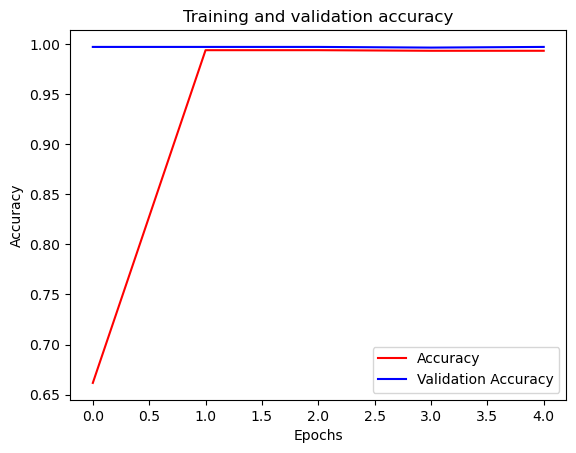

<Figure size 640x480 with 0 Axes>

47/47 [==============================] - 2s 34ms/step
F1 score : [0.5714286  0.29126215 0.63803685 0.04705882 0.60240966 0.10810811]


In [16]:
# Affichage des courbes de métriques
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()
plt.show()

# Affichage du F1 score
predictions = model.predict(test_sequences)
predictions = np.round(predictions)
print(f"F1 score : {f1_score(test_labels, predictions)}")

In [17]:
# On peut de nouveau itérer sur le modèle pour améliorer les résultats.
# Pour cela, on va utiliser une matrice d'embedding.
embedding_dim = 100
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

embeddings_index = {};

with open('./data/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [18]:
# Création du modèle
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    LSTM(units=60, return_sequences=True),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(6, activation='sigmoid')
])

# Création de la métrique F1
f1_score = tfa.metrics.F1Score(num_classes=6, threshold=0.9)

# Compilation du modèle
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', f1_score])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          4205500   
                                                                 
 lstm_1 (LSTM)               (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [19]:
# Entrainement du modèle
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels),batch_size=32)

Epoch 1/5
422/422 [==============================] - 35s 79ms/step - loss: 0.9179 - accuracy: 0.7186 - f1_score: 0.0570 - val_loss: 0.3965 - val_accuracy: 0.9933 - val_f1_score: 0.3257
Epoch 2/5
422/422 [==============================] - 31s 73ms/step - loss: 2.3120 - accuracy: 0.9879 - f1_score: 0.3289 - val_loss: 0.8478 - val_accuracy: 0.9973 - val_f1_score: 0.3564
Epoch 3/5
422/422 [==============================] - 30s 71ms/step - loss: 3.8000 - accuracy: 0.9921 - f1_score: 0.3806 - val_loss: 2.1475 - val_accuracy: 0.9947 - val_f1_score: 0.3644
Epoch 4/5
422/422 [==============================] - 30s 72ms/step - loss: 6.8430 - accuracy: 0.9939 - f1_score: 0.3311 - val_loss: 2.7762 - val_accuracy: 0.9973 - val_f1_score: 0.1823
Epoch 5/5
422/422 [==============================] - 31s 73ms/step - loss: 9.1297 - accuracy: 0.9939 - f1_score: 0.3366 - val_loss: 5.3216 - val_accuracy: 0.9973 - val_f1_score: 0.3522


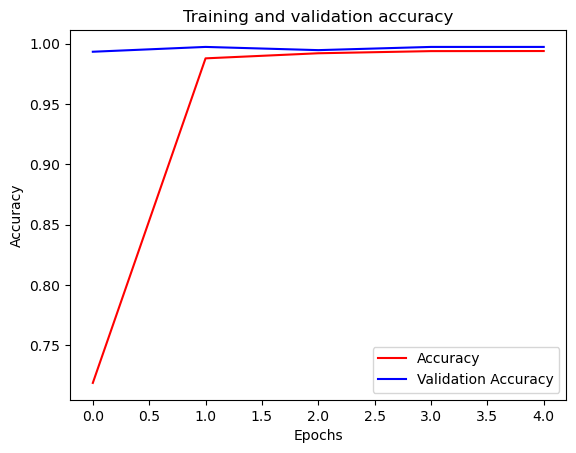

<Figure size 640x480 with 0 Axes>

47/47 [==============================] - 1s 24ms/step
F1 score : [0.4975124  0.29333332 0.5864662  0.03921569 0.57352936 0.12307692]


In [20]:
# Affichage des courbes de métriques
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()
plt.show()

# Affichage du F1 score
predictions = model.predict(test_sequences)
predictions = np.round(predictions)
print(f"F1 score : {f1_score(test_labels, predictions)}")

# Pipeline et Classification

In [21]:
# Phrase à tester
sentence = "You are fucking stupid ! I hate you !"

# Passage en minuscule
sentence = sentence.lower()

# Tokenisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
sentence = tokenizer.tokenize(sentence)

# Suppression des stopwords
sentence = [word for word in sentence if word not in stopwords]

# Lemmatisation
sentence = [Word_Lemmatizer.lemmatize(word) for word in sentence]

# Reconstitution de la phrase
sentence = " ".join(sentence)

print("Phrase après prétraitement : " + sentence)

# Tokenisation de la phrase
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
sentence = tokenizer.texts_to_sequences([sentence])

# Padding de la phrase
sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence, maxlen=41870, padding='post', truncating='post')

Phrase après prétraitement : fucking stupid hate


In [22]:
# Prédiction du modèle
model.predict(sentence)

1/1 [==============================] - 1s 1s/step


array([[1., 1., 1., 1., 1., 1.]], dtype=float32)